In [426]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
from collections import deque  # Import deque for efficient queue operations

class imageProcessor():
    def __init__(self, image_path, x_pix, y_pix):
        # Constructor to initialize the image processor object.
        # Reads the image, sets up the seed pixel and threshold values.
        
        self.readImage(image_path)  # Read the DICOM image from the given path
        self.row, self.col = self.ds.shape  # Get the dimensions of the image (rows, columns)
        
        # Normalize the image pixel values to range [0, 1] by dividing by the maximum value
        self.img_intent = self.ds / self.ds.max()  
        
        # Initialize an empty mask with the same shape as the image
        self.mask = np.zeros((self.row, self.col))
        
        # Initialize an array to store gradient information from the Sobel Filter
        self.gradient = np.zeros((self.row, self.col))

        # Set the seed pixel (starting point) coordinates
        self.seed_row = y_pix
        self.seed_col = x_pix
        
    def readImage(self, img_path):
        # This function reads a DICOM image from the specified file path.
        # Extracts the pixel array from the image and stores it as `self.ds`.
        
        img = dicom.dcmread(img_path)  # Read the DICOM file
        self.ds = img.pixel_array  # Extract the pixel array from the DICOM image

    def showMask(self):
        # Display the mask image using matplotlib
        plt.imshow(self.mask, 'gray')

    def showImage(self):
        # Display the image pixel intensity array using matplotlib
        plt.imshow(self.img_intent, 'gray')

    def sobelFilter(self, x, y):
        # Sobel kernels for x and y gradients
        x_kernal = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]])

        y_kernal = np.array([[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]])

        # Check if (x, y) is within the valid range (not at the borders)
        if 0 < x < self.col - 1 and 0 < y < self.row - 1:
            # Load the 3x3 region around the pixel (x, y)
            filter_region = self.img_intent[y-1:y+2, x-1:x+2]

            # Compute the x and y gradients of the pixel using convolution
            x_grad = np.sum(filter_region * x_kernal)
            y_grad = np.sum(filter_region * y_kernal)

            # Compute the magnitude of the gradient and store it back in the gradient array
            self.gradient[y, x] = np.sqrt(x_grad**2 + y_grad**2)

    def edgeThreshold(self, edge_thresh):
        # Apply Sobel filter to calculate gradient magnitudes
        self.sobelFilter(self.seed_col, self.seed_row)

        # Set the gradient threshold based on the seed pixel's gradient value
        thresh = self.gradient[self.seed_row, self.seed_col]*(1+edge_thresh)
        
        # Initialize the BFS queue with the seed pixel
        queue = deque([(self.seed_row, self.seed_col)])
        
        # Mark the seed pixel in the mask as visited (part of the region)
        self.mask[self.seed_row, self.seed_col] = 1

        # Perform BFS to grow the region
        while queue:
            current_row, current_col = queue.popleft()

            # Explore 4-connected neighbors (up, down, left, right)
            for delta_row, delta_col in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                neighbor_row = current_row + delta_row
                neighbor_col = current_col + delta_col
                
                # Ensure the neighbor is within image bounds and not visited
                if 0 <= neighbor_row < self.row and 0 <= neighbor_col < self.col and self.mask[neighbor_row, neighbor_col] == 0:
                    # Compute gradient with sobelFilter() function on the neighbor pixel address
                    self.sobelFilter(neighbor_col, neighbor_row)
                    
                    # Check if the neighbor's gradient is below the threshold
                    if self.gradient[neighbor_row, neighbor_col] <= thresh:
                        # Add the neighbor to the queue and mark it as part of the region (visited)
                        queue.append((neighbor_row, neighbor_col))
                        self.mask[neighbor_row, neighbor_col] = 1  # Mark as part of the region

    def intensityThreshold(self, intensity_thresh):
        # Calculate the average intensity of the masked region
        average_intensity = np.mean(self.img_intent[self.mask == 1])
        
        # Initialize a queue for processing pixels and a set to track visited pixels to avoid revisiting
        intensity_queue = deque([(self.seed_row, self.seed_col)])  # Add the seed pixel to the queue
        intensity_visited = set([(self.seed_row, self.seed_col)])  # Mark the seed pixel as visited

        # Directions for exploring neighboring pixels (right, down, left, up)
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # Right, Down, Left, Up

        # Start the region-growing process for intensity-based filling
        while intensity_queue:
            x, y = intensity_queue.popleft()  # Get the current pixel from the front of the queue

            # Explore all neighboring pixels (right, down, left, up)
            for dx, dy in directions:
                nx, ny = x + dx, y + dy  # Calculate the coordinates of the neighboring pixel

                # Check if the neighboring pixel is within the bounds of the image and not already visited
                if 0 <= nx < self.row and 0 <= ny < self.col and (nx, ny) not in intensity_visited:
                    # Check if the neighboring pixel is within the intensity threshold bounds
                    if (average_intensity*(1-intensity_thresh)) < self.img_intent[nx, ny] < (average_intensity*(1+intensity_thresh)):
                        # Mark the neighboring pixel as visited and add it to the queue for further processing
                        intensity_visited.add((nx, ny))
                        intensity_queue.append((nx, ny))
                        self.mask[nx, ny] = 1  # Mark the pixel as part of the region

    def process(self, edge_threshold, intensity_threshold):
        self.edgeThreshold(edge_threshold)
        self.intensityThreshold(intensity_threshold)
        

In [478]:
img_4 = imageProcessor('CT_data/i0092,0000b.dcm', 100, 200)
img_4.edgeThreshold(2.8)
b = img_4.mask.copy()

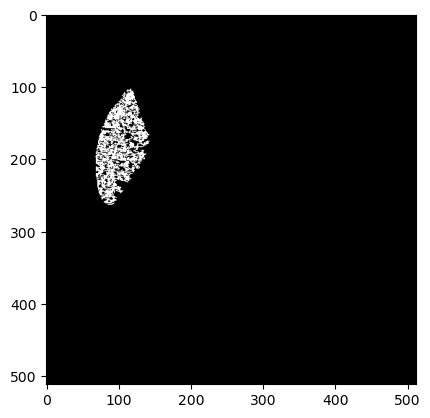

In [479]:
img_4.showMask()

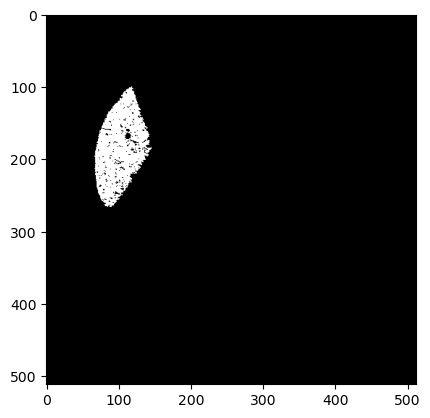

In [482]:
img_4.intensityThreshold(0.025)
a = img_4.mask
img_4.showMask()

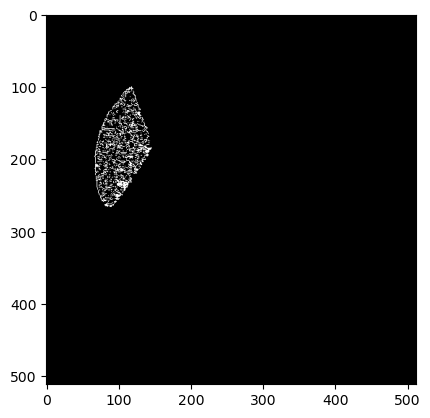

In [422]:
plt.imshow((a-b), 'gray')

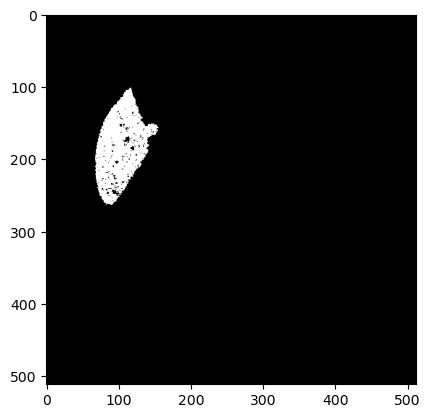

In [490]:
img_5 = imageProcessor('CT_data/i0094,0000b.dcm', 100, 200)
img_5.process(0.8,0.025)
img_5.showMask()

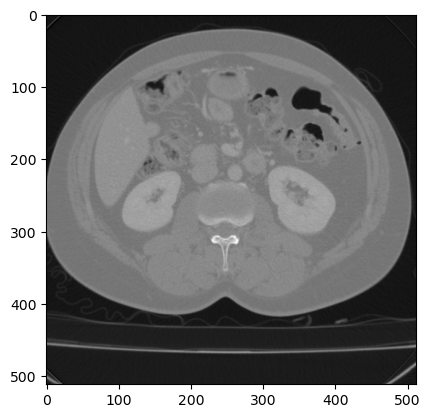

In [489]:
img_5.showImage()